<font size="5">Fashion-MNIST Multilayer Perceptron (TensorFlow)</font>

<br />

<u>Upcoming<u/>
- Improve Performance
  - Tune hyperparameters (e.g., learning rate scheduling, neuron dropout rate) to optimize convergence and improve accuracy
    - Use Keras Tuner for cross-validation
- Evaluate Performance
  - Compare performance of later models to Model 1 on most error-prone classes
- Alternative Models
  - Compare "Neuron Dropout" model that improves generalization/reduces overfitting
  - Compare "Wide & Deep" model that learns simple rules and deep patterns 
  - Compare Convolutional Neural Network (CNN) to previous Sequential models

<br />

Development/progress notes below analysis

<br />

<u>Data/Task Notes<u/>
- Dataset contains 70,000 grayscale images of fashion items across 10 categories/classes, with information stored at the pixel level
  - Image dimensions are 28*28 pixels (784 total)
  - Data features consist of 784 pixel brightnesses (ranging from 0-255), with no colour (RGB/RGBA) information.
  - Data labels contain the true classification of each instance (integer encoding, 0-9).
- Since there is no emphasis on classifying any label in particular, and the full dataset conveniently includes equal proportions of all labels, train/validation/test sets are created with equal (stratified) proportions of instance labels.

In [2]:
#Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product
from pathlib import Path
from time import strftime
import datetime
import random
import warnings

#%load_ext tensorboard

<h4 align="center"> Section 1: DataFrame Transformations </h4>

In [3]:
#Import full CSV data as DataFrame
fmnist_full = pd.read_csv(r'C:\Users\darkw\Desktop\f_mnist_full.csv')
print(fmnist_full.shape)
fmnist_full.head(2)

(70000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Verify dtypes
fmnist_full.dtypes[:5]

label     int64
pixel1    int64
pixel2    int64
pixel3    int64
pixel4    int64
dtype: object

In [5]:
#Establish indexed class list
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
#Sample 1a: Visualize record stored in full DataFrame
 #Select random df record
sample1a = fmnist_full.sample(1)
 #Output category from df
s1a_class = sample1a['label'].values[0]
print('Item clothing category:', class_names[s1a_class])
 #Preview index + attribute values
print(sample1a[['label','pixel18','pixel392','pixel750']])

Item clothing category: T-shirt/top
       label  pixel18  pixel392  pixel750
25157      0      106         0       149


In [7]:
 #Store sample features
sample1a = sample1a.drop(sample1a[['label']], axis=1)
s1a_vals = sample1a.values[0]
 #Reshape features for visualization
s1a_img = s1a_vals.reshape(28, 28)

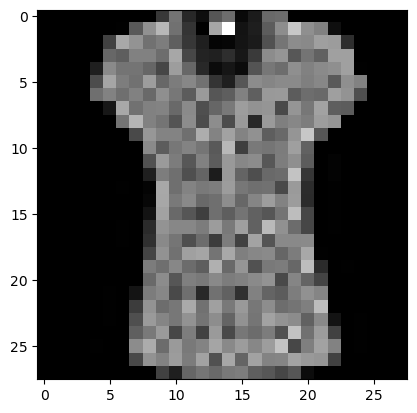

In [8]:
 #Display sample 1a in original cmap (grayscale)
plt.imshow(s1a_img, cmap='gray');

In [9]:
#Create target + feature dfs
y = fmnist_full['label']

X = fmnist_full.drop(fmnist_full[['label']], axis=1)
X.shape, y.shape

((70000, 784), (70000,))

In [10]:
#Review dataset balance
y.value_counts().sort_index()

label
0    7000
1    7000
2    7000
3    7000
4    7000
5    7000
6    7000
7    7000
8    7000
9    7000
Name: count, dtype: int64

In [11]:
#Transform target df to array
y = y.to_numpy()
y.shape

(70000,)

In [12]:
#Transform feature df to array + reshape for input layer
X_28 = X.to_numpy().reshape(70000, 28, 28)
X_28.shape

(70000, 28, 28)

<h4 align="center"> Section 2: Array Transformations </h4>

In [13]:
#Sample 1b: Re-locate sample 1a in array; visualize to verify
 #Store 1a index value; output to verify
s1_index = sample1a.index
s1_index

Index([25157], dtype='int64')

In [14]:
 #Output category from label array
s1b_class = y[s1_index][0]

print('Item clothing category:', class_names[s1b_class])

Item clothing category: T-shirt/top


In [15]:
 #Store feature values from reshaped array
sample1b = X_28[s1_index][0]
 #Display integer dtype/values
print(sample1b.dtype)
sample1b[0][0:40]

int64


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,  57, 116,  41,  14,
        86, 109,   9,  27, 106, 108,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int64)

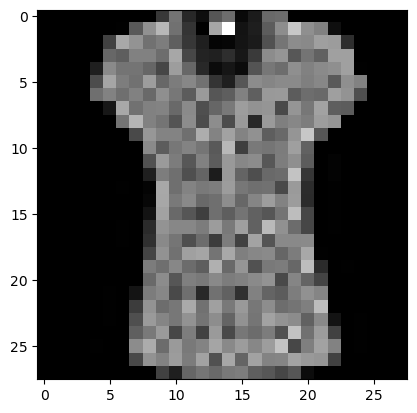

In [16]:
 #Display sample 1b in original cmap (grayscale)
plt.imshow(sample1b, cmap='gray');

In [17]:
#Split full dataset into 60,000 train + 10,000 test, maintaining label balance
X_train_full, X_te, y_train_full, y_te = train_test_split(X_28, y, test_size=1/7, stratify=y)

In [18]:
#Compare methods for creating validation set from training set
 #Keras training APIs include 'validation_split'; selects "the last samples in the x and y data provided, before shuffling"
  #Check last 5000 labels to evaluate would-be balance of validation set created by index slice/keras method
y_last5k = y_train_full[-5000:]

In [19]:
value1, count1 = np.unique(y_last5k, return_counts=True)

last5k_dict = dict(map(lambda label, freq : (label,freq) , value1, count1))

for i in last5k_dict:
    print(i, last5k_dict[i])

0 493
1 525
2 501
3 503
4 515
5 479
6 479
7 503
8 517
9 485


In [20]:
#Split training data into 55,000 train + 5,000 validation
 #Opting for sklearn 'train_test_split' to stratify by label, preserving label balance more precisely
X_train, X_valid, y_tr, y_val = train_test_split(X_train_full, y_train_full, test_size=1/12, stratify=y_train_full)

In [21]:
#Verify balance
 #Count label frequencies by set
value2, count2 = np.unique(y_tr, return_counts=True)
value3, count3 = np.unique(y_val, return_counts=True)
value4, count4 = np.unique(y_te, return_counts=True)

In [22]:
 #Map and display dictionaries
  #Training label frequencies
label_dict1 = dict(map(lambda label, freq : (label,freq) , value2, count2))

for i in label_dict1:
    print(i, label_dict1[i])

0 5500
1 5500
2 5500
3 5500
4 5500
5 5500
6 5500
7 5500
8 5500
9 5500


In [23]:
  #Validation label frequencies
label_dict2 = dict(map(lambda label, freq : (label,freq) , value3, count3))

for i in label_dict2:
    print(i, label_dict2[i])

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [24]:
  #Test label frequencies
label_dict3 = dict(map(lambda label, freq : (label,freq) , value4, count4))

for i in label_dict3:
    print(i, label_dict3[i])

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


In [25]:
#Preview feature (pre-scaling) and label values from arrays
 #features
X_valid[:1][0][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [26]:
 #label
y_val[:1]

array([7], dtype=int64)

In [27]:
#Scale feature arrays from 0-255 (int) to 0.0-1.0 (float)
X_tr_sc, X_val_sc, X_te_sc = X_train/255., X_valid/255., X_te/255.

In [28]:
#Check post-scaling dtypes
X_tr_sc.dtype, X_val_sc.dtype, X_te_sc.dtype

(dtype('float64'), dtype('float64'), dtype('float64'))

<h4 align="center"> Section 3: Tensor transformations </h4>

In [29]:
#Transform feature + label sets to tensors; reduce respective precisions
X_tr_sc = tf.convert_to_tensor(X_tr_sc, dtype=tf.float32)
X_val_sc = tf.convert_to_tensor(X_val_sc, dtype=tf.float32)
X_te_sc = tf.convert_to_tensor(X_te_sc, dtype=tf.float32)

y_tr = tf.convert_to_tensor(y_tr, dtype=tf.int8)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int8)
y_te = tf.convert_to_tensor(y_te, dtype=tf.int8)

In [30]:
 #Verify shapes
print(X_tr_sc.shape, y_tr.shape)
print(X_val_sc.shape, y_val.shape)
print(X_te_sc.shape, y_te.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [31]:
#Sample 2: Visualize post-splits, post-scaling sample from tensor
sample2 = X_tr_sc[0]
 #Verify transformation of features to float dtype; preview values
print(sample2.dtype)
sample2[27]

<dtype: 'float32'>


<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00392157,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00392157, 0.        ,
       0.        , 0.13725491, 0.09019608, 0.08627451, 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)>

In [32]:
 #Output sample label + category from tensor
print(y_tr[0])

s2_class = y_tr[0]
print(class_names[s2_class])

tf.Tensor(4, shape=(), dtype=int8)
Coat


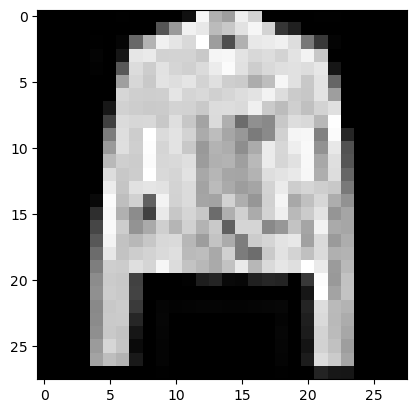

In [33]:
 #Display sample 2
plt.imshow(sample2, cmap='gray');

<h4 align="center"> Section 4: Model Building, Training & Storage </h4>

In [34]:
#TensorBoard log directory setup
log_dir1 = "Tf_output/fit/FMNIST/M1_Base_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir2 = "Tf_output/fit/FMNIST/M2_Wide_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir3 = "Tf_output/fit/FMNIST/M3_Uni_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir4 = "Tf_output/fit/FMNIST/M4_Deep_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#Define callbacks
 #Event log callbacks
event_cb1 = tf.keras.callbacks.TensorBoard(log_dir=log_dir1, histogram_freq=1)
event_cb2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)
event_cb3 = tf.keras.callbacks.TensorBoard(log_dir=log_dir3, histogram_freq=1)
event_cb4 = tf.keras.callbacks.TensorBoard(log_dir=log_dir4, histogram_freq=1)
 #Model checkpoint callback
checkp_cb1 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/M1_Base", save_best_only=True)
checkp_cb2 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/M2_Wide", save_best_only=True)
checkp_cb3 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/M3_Uni", save_best_only=True)
checkp_cb4 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/M4_Deep", save_best_only=True)
 #Early stopping callback
stop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=20)

#Bundle
cb_list1 = [event_cb1, checkp_cb1, stop_cb]
cb_list2 = [event_cb2, checkp_cb2, stop_cb]
cb_list3 = [event_cb3, checkp_cb3, stop_cb]
cb_list4 = [event_cb4, checkp_cb4, stop_cb]

In [36]:
#Build Network 1: "Base"
 #2 hidden layers (300 * 100 nodes)
dnn1 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28]),
tf.keras.layers.Dense(300, activation='relu'),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

dnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
#Build Network 2: "Wide"
 #2 hidden layers
dnn2 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28]),
tf.keras.layers.Dense(334, activation='relu'),
tf.keras.layers.Dense(12, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

dnn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 334)               262190    
                                                                 
 dense_7 (Dense)             (None, 12)                4020      
                                                                 
 dense_8 (Dense)             (None, 10)                130       
                                                                 
Total params: 266340 (1.02 MB)
Trainable params: 266340 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
#Build Network 3: "Uniform"
 #3 hidden layers (200*200 nodes)
dnn3 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28]),
tf.keras.layers.Dense(217, activation='relu'),
tf.keras.layers.Dense(216, activation='relu'),
tf.keras.layers.Dense(216, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

dnn3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 217)               170345    
                                                                 
 dense_10 (Dense)            (None, 216)               47088     
                                                                 
 dense_11 (Dense)            (None, 216)               46872     
                                                                 
 dense_12 (Dense)            (None, 10)                2170      
                                                                 
Total params: 266475 (1.02 MB)
Trainable params: 266475 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
#Build Network 4: "Deep"
 #3 hidden layers (134*133*133 nodes)
dnn4 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28]),
tf.keras.layers.Dense(194, activation='relu'),
tf.keras.layers.Dense(194, activation='relu'),
tf.keras.layers.Dense(192, activation='relu'),
tf.keras.layers.Dense(192, activation='relu'),
tf.keras.layers.Dense(10, activation='softmax')
])

dnn4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_13 (Dense)            (None, 194)               152290    
                                                                 
 dense_14 (Dense)            (None, 194)               37830     
                                                                 
 dense_15 (Dense)            (None, 192)               37440     
                                                                 
 dense_16 (Dense)            (None, 192)               37056     
                                                                 
 dense_17 (Dense)            (None, 10)                1930      
                                                                 
Total params: 266546 (1.02 MB)
Trainable params: 26654

In [40]:
#Preview initialized trainable parameters (weights and biases) for third layer of Model 1
 #Access + store third layer (second dense; 100 neurons)
layer_100node = dnn1.layers[2]
layer_100node.name

'dense_4'

In [41]:
 #Store trainable parameters (30,000 weights, 100 biases)
weights_100, biases_100 = layer_100node.get_weights()

 #For densely connected layer, shape of 2-dimensional array containing weights between every neuron of previous (input) and selected layer 
print(weights_100.shape)
 #Preview array of randomly initialized weights
weights_100

(300, 100)


array([[ 0.08145747, -0.04424927,  0.11458821, ...,  0.01960892,
         0.04272447, -0.05757496],
       [-0.07597455, -0.0902677 ,  0.06408349, ...,  0.03108951,
         0.06876855,  0.09782214],
       [ 0.05406921, -0.09749772, -0.05373177, ...,  0.11921229,
         0.12176179,  0.0965224 ],
       ...,
       [-0.10968261, -0.09764337,  0.01585419, ..., -0.00886743,
        -0.07389144, -0.06028783],
       [ 0.04571012,  0.01271322,  0.00899202, ..., -0.01552816,
         0.07484675, -0.0667997 ],
       [ 0.00854421, -0.0004003 , -0.02207427, ..., -0.11434909,
        -0.09096383, -0.02012533]], dtype=float32)

In [42]:
print(biases_100.shape)
 #Output untrained biases for each neuron
biases_100

(100,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [43]:
#Configure optimizers, loss functions & performance metrics
optimizer1 = tf.keras.optimizers.SGD() #default: 0.01
optimizer2 = tf.keras.optimizers.SGD()
optimizer3 = tf.keras.optimizers.SGD()
optimizer4 = tf.keras.optimizers.SGD()

dnn1.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer1,
                   metrics=['accuracy'])

dnn2.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer2,
                   metrics=['accuracy'])

dnn3.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer3,
                   metrics=['accuracy'])

dnn4.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer4,
                   metrics=['accuracy'])

In [44]:
#Train networks + store results
epoch_count = 50

#Method 1: Train individually
 #Train Model 1
#history1 = dnn1.fit(X_tr_sc, y_tr, epochs=epoch_count, validation_data=(X_val_sc, y_val), callbacks=cb_list1, verbose=2)

In [45]:
 #Train Model 2
#history2 = dnn2.fit(X_tr_sc, y_tr, epochs=epoch_count, validation_data=(X_val_sc, y_val), callbacks=cb_list2, verbose=2)

In [46]:
 #Train Model 3
#history3 = dnn3.fit(X_tr_sc, y_tr, epochs=epoch_count, validation_data=(X_val_sc, y_val), callbacks=cb_list3, verbose=2)

In [47]:
 #Train Model 4
#history4 = dnn4.fit(X_tr_sc, y_tr, epochs=epoch_count, validation_data=(X_val_sc, y_val), callbacks=cb_list4, verbose=2)

In [49]:
 #Method 2: train all using loop
train_array = [[dnn1, cb_list1], 
              [dnn2, cb_list2],
              [dnn3, cb_list3],
              [dnn4, cb_list4]]

  #Container for history objects
history_list = []

  #Training loop
for network in train_array:
    dnn = network[0]
    CBs = network[1]
    history = dnn.fit(X_tr_sc, y_tr, epochs=epoch_count, validation_data=(X_val_sc, y_val), callbacks=CBs, verbose=2)
    history_list.append(history)

  #Store history objects in variables
history1 = history_list[0]
history2 = history_list[1]
history3 = history_list[2]
history4 = history_list[3]

Epoch 1/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 3s - loss: 0.4683 - accuracy: 0.8369 - val_loss: 0.4630 - val_accuracy: 0.8348 - 3s/epoch - 2ms/step
Epoch 2/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 3s - loss: 0.4319 - accuracy: 0.8502 - val_loss: 0.4487 - val_accuracy: 0.8434 - 3s/epoch - 2ms/step
Epoch 3/50
1719/1719 - 3s - loss: 0.4065 - accuracy: 0.8577 - val_loss: 0.4516 - val_accuracy: 0.8364 - 3s/epoch - 2ms/step
Epoch 4/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 3s - loss: 0.3890 - accuracy: 0.8637 - val_loss: 0.3968 - val_accuracy: 0.8576 - 3s/epoch - 2ms/step
Epoch 5/50
1719/1719 - 3s - loss: 0.3730 - accuracy: 0.8692 - val_loss: 0.4181 - val_accuracy: 0.8472 - 3s/epoch - 2ms/step
Epoch 6/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 3s - loss: 0.3601 - accuracy: 0.8729 - val_loss: 0.3790 - val_accuracy: 0.8630 - 3s/epoch - 2ms/step
Epoch 7/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 5s - loss: 0.3493 - accuracy: 0.8754 - val_loss: 0.3718 - val_accuracy: 0.8620 - 5s/epoch - 3ms/step
Epoch 8/50
1719/1719 - 3s - loss: 0.3397 - accuracy: 0.8788 - val_loss: 0.3830 - val_accuracy: 0.8590 - 3s/epoch - 2ms/step
Epoch 9/50
1719/1719 - 3s - loss: 0.3307 - accuracy: 0.8823 - val_loss: 0.3827 - val_accuracy: 0.8648 - 3s/epoch - 2ms/step
Epoch 10/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.3226 - accuracy: 0.8840 - val_loss: 0.3469 - val_accuracy: 0.8752 - 4s/epoch - 3ms/step
Epoch 11/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.3155 - accuracy: 0.8869 - val_loss: 0.3461 - val_accuracy: 0.8742 - 4s/epoch - 2ms/step
Epoch 12/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.3085 - accuracy: 0.8890 - val_loss: 0.3336 - val_accuracy: 0.8794 - 4s/epoch - 2ms/step
Epoch 13/50
1719/1719 - 3s - loss: 0.3019 - accuracy: 0.8918 - val_loss: 0.3356 - val_accuracy: 0.8766 - 3s/epoch - 2ms/step
Epoch 14/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 3s - loss: 0.2955 - accuracy: 0.8946 - val_loss: 0.3269 - val_accuracy: 0.8820 - 3s/epoch - 2ms/step
Epoch 15/50
1719/1719 - 3s - loss: 0.2892 - accuracy: 0.8967 - val_loss: 0.3303 - val_accuracy: 0.8796 - 3s/epoch - 2ms/step
Epoch 16/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.2841 - accuracy: 0.8971 - val_loss: 0.3205 - val_accuracy: 0.8836 - 4s/epoch - 2ms/step
Epoch 17/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.2788 - accuracy: 0.8999 - val_loss: 0.3153 - val_accuracy: 0.8820 - 4s/epoch - 2ms/step
Epoch 18/50
1719/1719 - 3s - loss: 0.2730 - accuracy: 0.9005 - val_loss: 0.3177 - val_accuracy: 0.8816 - 3s/epoch - 2ms/step
Epoch 19/50
1719/1719 - 3s - loss: 0.2684 - accuracy: 0.9031 - val_loss: 0.3185 - val_accuracy: 0.8828 - 3s/epoch - 2ms/step
Epoch 20/50
1719/1719 - 3s - loss: 0.2629 - accuracy: 0.9052 - val_loss: 0.3460 - val_accuracy: 0.8742 - 3s/epoch - 2ms/step
Epoch 21/50
1719/1719 - 4s - loss: 0.2591 - accuracy: 0.9075 - val_loss: 0.3226 - val_accuracy: 0.8772 - 4s/epoch - 2ms/step
Epoch 22/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.2549 - accuracy: 0.9071 - val_loss: 0.3037 - val_accuracy: 0.8864 - 4s/epoch - 2ms/step
Epoch 23/50
1719/1719 - 3s - loss: 0.2504 - accuracy: 0.9101 - val_loss: 0.3115 - val_accuracy: 0.8864 - 3s/epoch - 2ms/step
Epoch 24/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.2463 - accuracy: 0.9106 - val_loss: 0.3015 - val_accuracy: 0.8900 - 4s/epoch - 2ms/step
Epoch 25/50
1719/1719 - 3s - loss: 0.2411 - accuracy: 0.9125 - val_loss: 0.3101 - val_accuracy: 0.8882 - 3s/epoch - 2ms/step
Epoch 26/50
1719/1719 - 3s - loss: 0.2379 - accuracy: 0.9144 - val_loss: 0.3119 - val_accuracy: 0.8890 - 3s/epoch - 2ms/step
Epoch 27/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.2334 - accuracy: 0.9152 - val_loss: 0.2956 - val_accuracy: 0.8912 - 4s/epoch - 2ms/step
Epoch 28/50
1719/1719 - 3s - loss: 0.2301 - accuracy: 0.9175 - val_loss: 0.3048 - val_accuracy: 0.8870 - 3s/epoch - 2ms/step
Epoch 29/50
1719/1719 - 3s - loss: 0.2252 - accuracy: 0.9181 - val_loss: 0.3106 - val_accuracy: 0.8850 - 3s/epoch - 2ms/step
Epoch 30/50
1719/1719 - 4s - loss: 0.2221 - accuracy: 0.9204 - val_loss: 0.2963 - val_accuracy: 0.8914 - 4s/epoch - 2ms/step
Epoch 31/50
1719/1719 - 3s - loss: 0.2191 - accuracy: 0.9210 - val_loss: 0.3123 - val_accuracy: 0.8836 - 3s/epoch - 2ms/step
Epoch 32/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.2137 - accuracy: 0.9237 - val_loss: 0.2937 - val_accuracy: 0.8920 - 4s/epoch - 2ms/step
Epoch 33/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.2119 - accuracy: 0.9240 - val_loss: 0.2878 - val_accuracy: 0.8940 - 4s/epoch - 2ms/step
Epoch 34/50
1719/1719 - 3s - loss: 0.2086 - accuracy: 0.9246 - val_loss: 0.2911 - val_accuracy: 0.8924 - 3s/epoch - 2ms/step
Epoch 35/50
1719/1719 - 4s - loss: 0.2056 - accuracy: 0.9259 - val_loss: 0.2920 - val_accuracy: 0.8920 - 4s/epoch - 2ms/step
Epoch 36/50
1719/1719 - 3s - loss: 0.2005 - accuracy: 0.9288 - val_loss: 0.3263 - val_accuracy: 0.8854 - 3s/epoch - 2ms/step
Epoch 37/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.1979 - accuracy: 0.9293 - val_loss: 0.2856 - val_accuracy: 0.8956 - 4s/epoch - 2ms/step
Epoch 38/50
1719/1719 - 3s - loss: 0.1939 - accuracy: 0.9310 - val_loss: 0.2908 - val_accuracy: 0.8930 - 3s/epoch - 2ms/step
Epoch 39/50
1719/1719 - 3s - loss: 0.1914 - accuracy: 0.9315 - val_loss: 0.2987 - val_accuracy: 0.8902 - 3s/epoch - 2ms/step
Epoch 40/50
1719/1719 - 3s - loss: 0.1886 - accuracy: 0.9323 - val_loss: 0.2874 - val_accuracy: 0.8944 - 3s/epoch - 2ms/step
Epoch 41/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M1_Base\assets


1719/1719 - 4s - loss: 0.1864 - accuracy: 0.9336 - val_loss: 0.2841 - val_accuracy: 0.8952 - 4s/epoch - 2ms/step
Epoch 42/50
1719/1719 - 3s - loss: 0.1841 - accuracy: 0.9338 - val_loss: 0.2921 - val_accuracy: 0.8980 - 3s/epoch - 2ms/step
Epoch 43/50
1719/1719 - 3s - loss: 0.1794 - accuracy: 0.9365 - val_loss: 0.3257 - val_accuracy: 0.8832 - 3s/epoch - 2ms/step
Epoch 44/50
1719/1719 - 4s - loss: 0.1770 - accuracy: 0.9367 - val_loss: 0.3116 - val_accuracy: 0.8888 - 4s/epoch - 2ms/step
Epoch 45/50
1719/1719 - 3s - loss: 0.1741 - accuracy: 0.9383 - val_loss: 0.2932 - val_accuracy: 0.8932 - 3s/epoch - 2ms/step
Epoch 46/50
1719/1719 - 3s - loss: 0.1695 - accuracy: 0.9399 - val_loss: 0.2932 - val_accuracy: 0.8942 - 3s/epoch - 2ms/step
Epoch 1/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 4s - loss: 0.8644 - accuracy: 0.7228 - val_loss: 0.5545 - val_accuracy: 0.8138 - 4s/epoch - 2ms/step
Epoch 2/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 4s - loss: 0.5177 - accuracy: 0.8181 - val_loss: 0.4914 - val_accuracy: 0.8196 - 4s/epoch - 2ms/step
Epoch 3/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 4s - loss: 0.4681 - accuracy: 0.8340 - val_loss: 0.4655 - val_accuracy: 0.8316 - 4s/epoch - 2ms/step
Epoch 4/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 3s - loss: 0.4390 - accuracy: 0.8464 - val_loss: 0.4290 - val_accuracy: 0.8482 - 3s/epoch - 2ms/step
Epoch 5/50
1719/1719 - 3s - loss: 0.4186 - accuracy: 0.8527 - val_loss: 0.4421 - val_accuracy: 0.8462 - 3s/epoch - 2ms/step
Epoch 6/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 3s - loss: 0.4006 - accuracy: 0.8601 - val_loss: 0.4010 - val_accuracy: 0.8572 - 3s/epoch - 2ms/step
Epoch 7/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 4s - loss: 0.3854 - accuracy: 0.8645 - val_loss: 0.3833 - val_accuracy: 0.8662 - 4s/epoch - 2ms/step
Epoch 8/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 4s - loss: 0.3719 - accuracy: 0.8697 - val_loss: 0.3761 - val_accuracy: 0.8676 - 4s/epoch - 2ms/step
Epoch 9/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 3s - loss: 0.3599 - accuracy: 0.8738 - val_loss: 0.3721 - val_accuracy: 0.8678 - 3s/epoch - 2ms/step
Epoch 10/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 3s - loss: 0.3491 - accuracy: 0.8767 - val_loss: 0.3598 - val_accuracy: 0.8716 - 3s/epoch - 2ms/step
Epoch 11/50
1719/1719 - 3s - loss: 0.3393 - accuracy: 0.8792 - val_loss: 0.3655 - val_accuracy: 0.8700 - 3s/epoch - 2ms/step
Epoch 12/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 4s - loss: 0.3315 - accuracy: 0.8827 - val_loss: 0.3574 - val_accuracy: 0.8668 - 4s/epoch - 2ms/step
Epoch 13/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 3s - loss: 0.3228 - accuracy: 0.8846 - val_loss: 0.3537 - val_accuracy: 0.8712 - 3s/epoch - 2ms/step
Epoch 14/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 3s - loss: 0.3144 - accuracy: 0.8879 - val_loss: 0.3338 - val_accuracy: 0.8806 - 3s/epoch - 2ms/step
Epoch 15/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 3s - loss: 0.3071 - accuracy: 0.8895 - val_loss: 0.3290 - val_accuracy: 0.8792 - 3s/epoch - 2ms/step
Epoch 16/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 4s - loss: 0.3014 - accuracy: 0.8921 - val_loss: 0.3255 - val_accuracy: 0.8836 - 4s/epoch - 2ms/step
Epoch 17/50
1719/1719 - 3s - loss: 0.2948 - accuracy: 0.8950 - val_loss: 0.3324 - val_accuracy: 0.8760 - 3s/epoch - 2ms/step
Epoch 18/50
1719/1719 - 3s - loss: 0.2888 - accuracy: 0.8964 - val_loss: 0.3316 - val_accuracy: 0.8804 - 3s/epoch - 2ms/step
Epoch 19/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 4s - loss: 0.2842 - accuracy: 0.8972 - val_loss: 0.3214 - val_accuracy: 0.8832 - 4s/epoch - 2ms/step
Epoch 20/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 3s - loss: 0.2770 - accuracy: 0.9013 - val_loss: 0.3213 - val_accuracy: 0.8814 - 3s/epoch - 2ms/step
Epoch 21/50
1719/1719 - 3s - loss: 0.2732 - accuracy: 0.9017 - val_loss: 0.3240 - val_accuracy: 0.8806 - 3s/epoch - 2ms/step
Epoch 22/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 4s - loss: 0.2678 - accuracy: 0.9039 - val_loss: 0.3158 - val_accuracy: 0.8828 - 4s/epoch - 2ms/step
Epoch 23/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 3s - loss: 0.2626 - accuracy: 0.9043 - val_loss: 0.3131 - val_accuracy: 0.8858 - 3s/epoch - 2ms/step
Epoch 24/50
1719/1719 - 3s - loss: 0.2575 - accuracy: 0.9077 - val_loss: 0.3157 - val_accuracy: 0.8840 - 3s/epoch - 2ms/step
Epoch 25/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 4s - loss: 0.2536 - accuracy: 0.9088 - val_loss: 0.3095 - val_accuracy: 0.8882 - 4s/epoch - 2ms/step
Epoch 26/50
1719/1719 - 4s - loss: 0.2490 - accuracy: 0.9106 - val_loss: 0.3142 - val_accuracy: 0.8872 - 4s/epoch - 2ms/step
Epoch 27/50
1719/1719 - 3s - loss: 0.2449 - accuracy: 0.9125 - val_loss: 0.3222 - val_accuracy: 0.8814 - 3s/epoch - 2ms/step
Epoch 28/50
1719/1719 - 3s - loss: 0.2402 - accuracy: 0.9137 - val_loss: 0.3316 - val_accuracy: 0.8818 - 3s/epoch - 2ms/step
Epoch 29/50
1719/1719 - 3s - loss: 0.2375 - accuracy: 0.9145 - val_loss: 0.3137 - val_accuracy: 0.8862 - 3s/epoch - 2ms/step
Epoch 30/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M2_Wide\assets


1719/1719 - 4s - loss: 0.2324 - accuracy: 0.9158 - val_loss: 0.2936 - val_accuracy: 0.8944 - 4s/epoch - 2ms/step
Epoch 31/50
1719/1719 - 3s - loss: 0.2293 - accuracy: 0.9181 - val_loss: 0.3147 - val_accuracy: 0.8848 - 3s/epoch - 2ms/step
Epoch 32/50
1719/1719 - 3s - loss: 0.2245 - accuracy: 0.9191 - val_loss: 0.2971 - val_accuracy: 0.8916 - 3s/epoch - 2ms/step
Epoch 33/50
1719/1719 - 3s - loss: 0.2204 - accuracy: 0.9214 - val_loss: 0.3148 - val_accuracy: 0.8864 - 3s/epoch - 2ms/step
Epoch 34/50
1719/1719 - 3s - loss: 0.2184 - accuracy: 0.9210 - val_loss: 0.3071 - val_accuracy: 0.8870 - 3s/epoch - 2ms/step
Epoch 35/50
1719/1719 - 3s - loss: 0.2157 - accuracy: 0.9215 - val_loss: 0.2965 - val_accuracy: 0.8912 - 3s/epoch - 2ms/step
Epoch 1/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 5s - loss: 0.7618 - accuracy: 0.7440 - val_loss: 0.5349 - val_accuracy: 0.8122 - 5s/epoch - 3ms/step
Epoch 2/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.4855 - accuracy: 0.8303 - val_loss: 0.4849 - val_accuracy: 0.8230 - 4s/epoch - 2ms/step
Epoch 3/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.4369 - accuracy: 0.8458 - val_loss: 0.4347 - val_accuracy: 0.8474 - 4s/epoch - 2ms/step
Epoch 4/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.4073 - accuracy: 0.8550 - val_loss: 0.3903 - val_accuracy: 0.8610 - 4s/epoch - 2ms/step
Epoch 5/50
1719/1719 - 4s - loss: 0.3860 - accuracy: 0.8630 - val_loss: 0.4090 - val_accuracy: 0.8524 - 4s/epoch - 2ms/step
Epoch 6/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.3670 - accuracy: 0.8693 - val_loss: 0.3699 - val_accuracy: 0.8690 - 4s/epoch - 2ms/step
Epoch 7/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.3533 - accuracy: 0.8740 - val_loss: 0.3598 - val_accuracy: 0.8714 - 4s/epoch - 2ms/step
Epoch 8/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.3412 - accuracy: 0.8779 - val_loss: 0.3466 - val_accuracy: 0.8724 - 4s/epoch - 2ms/step
Epoch 9/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 5s - loss: 0.3306 - accuracy: 0.8811 - val_loss: 0.3437 - val_accuracy: 0.8704 - 5s/epoch - 3ms/step
Epoch 10/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.3202 - accuracy: 0.8846 - val_loss: 0.3369 - val_accuracy: 0.8722 - 4s/epoch - 3ms/step
Epoch 11/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.3118 - accuracy: 0.8872 - val_loss: 0.3366 - val_accuracy: 0.8770 - 4s/epoch - 3ms/step
Epoch 12/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.3039 - accuracy: 0.8899 - val_loss: 0.3246 - val_accuracy: 0.8816 - 4s/epoch - 3ms/step
Epoch 13/50
1719/1719 - 4s - loss: 0.2965 - accuracy: 0.8922 - val_loss: 0.3390 - val_accuracy: 0.8734 - 4s/epoch - 2ms/step
Epoch 14/50
1719/1719 - 4s - loss: 0.2893 - accuracy: 0.8940 - val_loss: 0.3263 - val_accuracy: 0.8804 - 4s/epoch - 2ms/step
Epoch 15/50
1719/1719 - 4s - loss: 0.2829 - accuracy: 0.8971 - val_loss: 0.3552 - val_accuracy: 0.8644 - 4s/epoch - 2ms/step
Epoch 16/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.2773 - accuracy: 0.8986 - val_loss: 0.3246 - val_accuracy: 0.8818 - 4s/epoch - 2ms/step
Epoch 17/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.2711 - accuracy: 0.9003 - val_loss: 0.3156 - val_accuracy: 0.8812 - 4s/epoch - 3ms/step
Epoch 18/50
1719/1719 - 3s - loss: 0.2650 - accuracy: 0.9026 - val_loss: 0.3604 - val_accuracy: 0.8734 - 3s/epoch - 2ms/step
Epoch 19/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.2600 - accuracy: 0.9045 - val_loss: 0.3084 - val_accuracy: 0.8894 - 4s/epoch - 2ms/step
Epoch 20/50
1719/1719 - 3s - loss: 0.2557 - accuracy: 0.9067 - val_loss: 0.3118 - val_accuracy: 0.8860 - 3s/epoch - 2ms/step
Epoch 21/50
1719/1719 - 4s - loss: 0.2504 - accuracy: 0.9087 - val_loss: 0.3185 - val_accuracy: 0.8806 - 4s/epoch - 2ms/step
Epoch 22/50
1719/1719 - 4s - loss: 0.2446 - accuracy: 0.9098 - val_loss: 0.3149 - val_accuracy: 0.8840 - 4s/epoch - 2ms/step
Epoch 23/50
1719/1719 - 3s - loss: 0.2400 - accuracy: 0.9128 - val_loss: 0.3108 - val_accuracy: 0.8846 - 3s/epoch - 2ms/step
Epoch 24/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.2353 - accuracy: 0.9133 - val_loss: 0.3057 - val_accuracy: 0.8864 - 4s/epoch - 2ms/step
Epoch 25/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.2308 - accuracy: 0.9159 - val_loss: 0.3053 - val_accuracy: 0.8900 - 4s/epoch - 3ms/step
Epoch 26/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.2253 - accuracy: 0.9184 - val_loss: 0.2966 - val_accuracy: 0.8920 - 4s/epoch - 2ms/step
Epoch 27/50
1719/1719 - 3s - loss: 0.2222 - accuracy: 0.9193 - val_loss: 0.2991 - val_accuracy: 0.8924 - 3s/epoch - 2ms/step
Epoch 28/50
1719/1719 - 4s - loss: 0.2181 - accuracy: 0.9197 - val_loss: 0.3001 - val_accuracy: 0.8906 - 4s/epoch - 2ms/step
Epoch 29/50
1719/1719 - 4s - loss: 0.2134 - accuracy: 0.9223 - val_loss: 0.3105 - val_accuracy: 0.8912 - 4s/epoch - 2ms/step
Epoch 30/50
1719/1719 - 4s - loss: 0.2114 - accuracy: 0.9220 - val_loss: 0.3024 - val_accuracy: 0.8908 - 4s/epoch - 2ms/step
Epoch 31/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.2065 - accuracy: 0.9248 - val_loss: 0.2943 - val_accuracy: 0.8962 - 4s/epoch - 2ms/step
Epoch 32/50
1719/1719 - 4s - loss: 0.2021 - accuracy: 0.9252 - val_loss: 0.2995 - val_accuracy: 0.8942 - 4s/epoch - 2ms/step
Epoch 33/50
1719/1719 - 4s - loss: 0.1986 - accuracy: 0.9268 - val_loss: 0.3076 - val_accuracy: 0.8906 - 4s/epoch - 2ms/step
Epoch 34/50
1719/1719 - 4s - loss: 0.1945 - accuracy: 0.9294 - val_loss: 0.2963 - val_accuracy: 0.8924 - 4s/epoch - 2ms/step
Epoch 35/50
1719/1719 - 3s - loss: 0.1913 - accuracy: 0.9294 - val_loss: 0.3150 - val_accuracy: 0.8926 - 3s/epoch - 2ms/step
Epoch 36/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M3_Uni\assets


1719/1719 - 4s - loss: 0.1878 - accuracy: 0.9319 - val_loss: 0.2915 - val_accuracy: 0.8984 - 4s/epoch - 2ms/step
Epoch 37/50
1719/1719 - 4s - loss: 0.1846 - accuracy: 0.9333 - val_loss: 0.3039 - val_accuracy: 0.8930 - 4s/epoch - 2ms/step
Epoch 38/50
1719/1719 - 4s - loss: 0.1809 - accuracy: 0.9346 - val_loss: 0.3018 - val_accuracy: 0.8944 - 4s/epoch - 2ms/step
Epoch 39/50
1719/1719 - 3s - loss: 0.1782 - accuracy: 0.9356 - val_loss: 0.3016 - val_accuracy: 0.8984 - 3s/epoch - 2ms/step
Epoch 40/50
1719/1719 - 3s - loss: 0.1745 - accuracy: 0.9369 - val_loss: 0.3250 - val_accuracy: 0.8892 - 3s/epoch - 2ms/step
Epoch 41/50
1719/1719 - 3s - loss: 0.1710 - accuracy: 0.9381 - val_loss: 0.3177 - val_accuracy: 0.8884 - 3s/epoch - 2ms/step
Epoch 1/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


1719/1719 - 5s - loss: 0.8049 - accuracy: 0.7241 - val_loss: 0.5400 - val_accuracy: 0.8106 - 5s/epoch - 3ms/step
Epoch 2/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


1719/1719 - 4s - loss: 0.4928 - accuracy: 0.8252 - val_loss: 0.4377 - val_accuracy: 0.8502 - 4s/epoch - 2ms/step
Epoch 3/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


1719/1719 - 4s - loss: 0.4387 - accuracy: 0.8439 - val_loss: 0.4275 - val_accuracy: 0.8510 - 4s/epoch - 2ms/step
Epoch 4/50
1719/1719 - 3s - loss: 0.4063 - accuracy: 0.8558 - val_loss: 0.4406 - val_accuracy: 0.8432 - 3s/epoch - 2ms/step
Epoch 5/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


1719/1719 - 4s - loss: 0.3804 - accuracy: 0.8638 - val_loss: 0.3910 - val_accuracy: 0.8600 - 4s/epoch - 3ms/step
Epoch 6/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


1719/1719 - 4s - loss: 0.3629 - accuracy: 0.8697 - val_loss: 0.3584 - val_accuracy: 0.8726 - 4s/epoch - 3ms/step
Epoch 7/50
1719/1719 - 4s - loss: 0.3462 - accuracy: 0.8756 - val_loss: 0.3645 - val_accuracy: 0.8664 - 4s/epoch - 2ms/step
Epoch 8/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


1719/1719 - 4s - loss: 0.3340 - accuracy: 0.8797 - val_loss: 0.3366 - val_accuracy: 0.8774 - 4s/epoch - 2ms/step
Epoch 9/50
1719/1719 - 4s - loss: 0.3241 - accuracy: 0.8824 - val_loss: 0.3582 - val_accuracy: 0.8658 - 4s/epoch - 2ms/step
Epoch 10/50
1719/1719 - 4s - loss: 0.3125 - accuracy: 0.8873 - val_loss: 0.3403 - val_accuracy: 0.8746 - 4s/epoch - 2ms/step
Epoch 11/50
1719/1719 - 4s - loss: 0.3035 - accuracy: 0.8910 - val_loss: 0.3509 - val_accuracy: 0.8680 - 4s/epoch - 2ms/step
Epoch 12/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


1719/1719 - 4s - loss: 0.2963 - accuracy: 0.8922 - val_loss: 0.3177 - val_accuracy: 0.8812 - 4s/epoch - 2ms/step
Epoch 13/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


1719/1719 - 5s - loss: 0.2880 - accuracy: 0.8957 - val_loss: 0.3175 - val_accuracy: 0.8834 - 5s/epoch - 3ms/step
Epoch 14/50
1719/1719 - 4s - loss: 0.2800 - accuracy: 0.8980 - val_loss: 0.3222 - val_accuracy: 0.8816 - 4s/epoch - 2ms/step
Epoch 15/50
1719/1719 - 4s - loss: 0.2731 - accuracy: 0.9009 - val_loss: 0.3198 - val_accuracy: 0.8804 - 4s/epoch - 2ms/step
Epoch 16/50
1719/1719 - 4s - loss: 0.2674 - accuracy: 0.9016 - val_loss: 0.3262 - val_accuracy: 0.8778 - 4s/epoch - 2ms/step
Epoch 17/50
1719/1719 - 4s - loss: 0.2611 - accuracy: 0.9044 - val_loss: 0.3182 - val_accuracy: 0.8834 - 4s/epoch - 2ms/step
Epoch 18/50
1719/1719 - 4s - loss: 0.2552 - accuracy: 0.9049 - val_loss: 0.3420 - val_accuracy: 0.8708 - 4s/epoch - 2ms/step
Epoch 19/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


1719/1719 - 4s - loss: 0.2494 - accuracy: 0.9081 - val_loss: 0.3048 - val_accuracy: 0.8860 - 4s/epoch - 2ms/step
Epoch 20/50
INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


INFO:tensorflow:Assets written to: Tf_output/checkpoints/FMNIST\M4_Deep\assets


1719/1719 - 4s - loss: 0.2429 - accuracy: 0.9102 - val_loss: 0.2969 - val_accuracy: 0.8922 - 4s/epoch - 2ms/step
Epoch 21/50
1719/1719 - 4s - loss: 0.2381 - accuracy: 0.9121 - val_loss: 0.3008 - val_accuracy: 0.8902 - 4s/epoch - 2ms/step
Epoch 22/50
1719/1719 - 4s - loss: 0.2335 - accuracy: 0.9136 - val_loss: 0.3418 - val_accuracy: 0.8798 - 4s/epoch - 2ms/step
Epoch 23/50
1719/1719 - 4s - loss: 0.2280 - accuracy: 0.9165 - val_loss: 0.3151 - val_accuracy: 0.8854 - 4s/epoch - 2ms/step
Epoch 24/50
1719/1719 - 4s - loss: 0.2228 - accuracy: 0.9167 - val_loss: 0.3106 - val_accuracy: 0.8874 - 4s/epoch - 2ms/step
Epoch 25/50
1719/1719 - 4s - loss: 0.2173 - accuracy: 0.9192 - val_loss: 0.3261 - val_accuracy: 0.8828 - 4s/epoch - 2ms/step
Epoch 26/50
1719/1719 - 4s - loss: 0.2140 - accuracy: 0.9208 - val_loss: 0.3213 - val_accuracy: 0.8872 - 4s/epoch - 2ms/step


In [62]:
history_list

In [51]:
#Preview post-training parameters for previously accessed (third) Model 1 layer
weights_100_tr, biases_100_tr = layer_100node.get_weights()
 #Trained weights
weights_100_tr

array([[ 0.08334175, -0.04349426,  0.11462127, ...,  0.01543408,
         0.04412948, -0.0564283 ],
       [-0.04362945, -0.11840182,  0.13263835, ...,  0.03763092,
         0.07542766,  0.13361526],
       [ 0.05432171, -0.09666934, -0.05579317, ...,  0.11985979,
         0.12217937,  0.09666649],
       ...,
       [-0.10706555, -0.09726471,  0.01035278, ..., -0.005738  ,
        -0.06910867, -0.06155764],
       [ 0.04286841,  0.01486188,  0.00143368, ..., -0.02800636,
         0.07313317, -0.07744176],
       [-0.00062357, -0.0268599 ,  0.00484807, ..., -0.13675621,
        -0.10005412, -0.01527028]], dtype=float32)

In [52]:
 #Trained biases
biases_100_tr

array([ 0.01781478,  0.03654785, -0.01016811,  0.04305866,  0.01802533,
       -0.00159448, -0.00873329,  0.05800824,  0.04789124,  0.05161469,
        0.12501805, -0.03065361,  0.00375979,  0.04854381,  0.13221239,
        0.04191285,  0.09081713,  0.11963776,  0.00336327,  0.11400875,
       -0.04272383,  0.1086018 ,  0.01973424,  0.01499008,  0.0218748 ,
       -0.03939278,  0.09446098,  0.08604281,  0.03384453,  0.06677151,
        0.18841638,  0.05888799,  0.09055602,  0.0365712 ,  0.00269573,
        0.02086487, -0.11174858,  0.19004469,  0.0558464 , -0.05091121,
       -0.01285927,  0.20775656,  0.14355287, -0.04319882, -0.0031596 ,
        0.00300719,  0.08551035,  0.02781454,  0.13604161,  0.15362333,
        0.05330969,  0.00683078,  0.05609847,  0.05533801,  0.06532204,
        0.12369604, -0.00059487,  0.09682489,  0.02156659, -0.10151283,
        0.07687818, -0.07829753,  0.11322854,  0.12757696, -0.10060889,
        0.00034616, -0.00171513,  0.07890768,  0.02002608,  0.02

In [53]:
#Verify Early Stopping CB is returning separate weights
#node2 = dnn2.layers[2]
#node3 = dnn3.layers[2]

#weights2, biases2 = node2.get_weights()
#weights3, biases3 = node3.get_weights()

#weights2

In [54]:
#biases2

In [55]:
#weights3

In [56]:
#Save best models
dnn1.save("Tf_output/models/FMNIST/best_dnn1", save_format="tf")

dnn2.save("Tf_output/models/FMNIST/best_dnn2", save_format="tf")

dnn3.save("Tf_output/models/FMNIST/best_dnn3", save_format="tf")

dnn4.save("Tf_output/models/FMNIST/best_dnn4", save_format="tf")

INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn1\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn1\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn2\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn2\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn3\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn3\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn4\assets


INFO:tensorflow:Assets written to: Tf_output/models/FMNIST/best_dnn4\assets


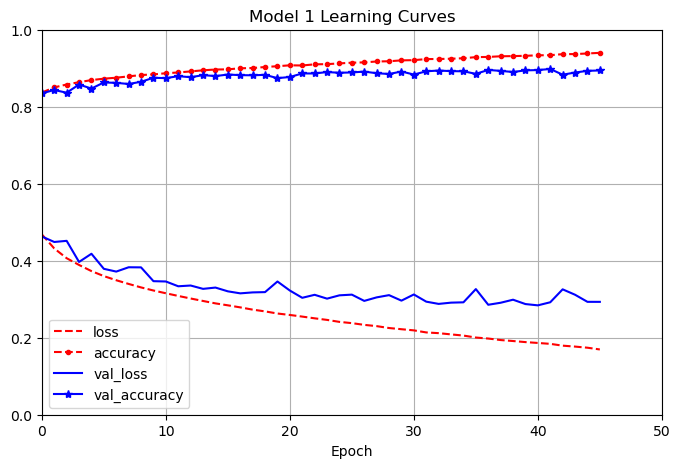

In [57]:
#Visualize learning curves manually
 #Model 1
dnn1_learn_curves = pd.DataFrame(history1.history).plot(
    figsize=(8,5), xlim=[0,epoch_count], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'], title='Model 1 Learning Curves')
plt.show()

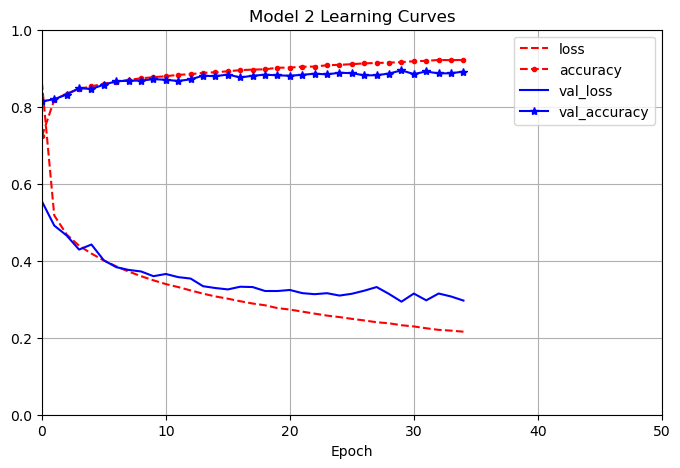

In [58]:
 #Model 2
dnn2_learn_curves = pd.DataFrame(history2.history).plot(
    figsize=(8,5), xlim=[0,epoch_count], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'], title='Model 2 Learning Curves')
plt.show()

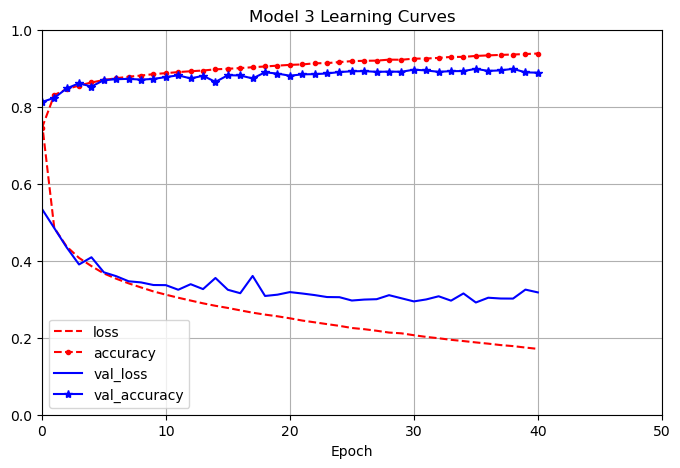

In [59]:
 #Model 3
dnn3_learn_curves = pd.DataFrame(history3.history).plot(
    figsize=(8,5), xlim=[0,epoch_count], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'], title='Model 3 Learning Curves')
plt.show()

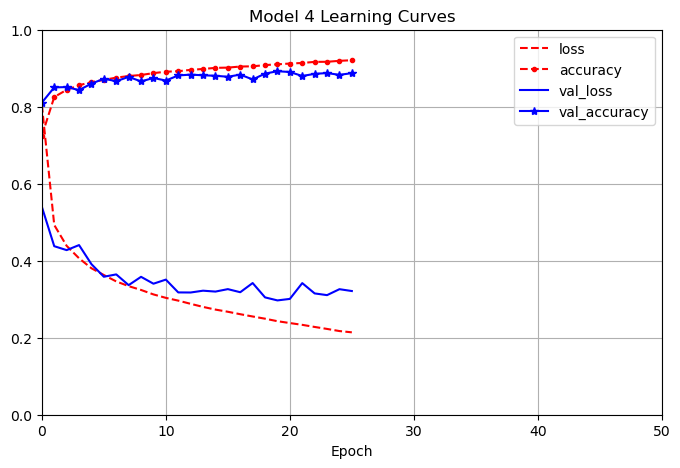

In [60]:
 #Model 4
dnn4_learn_curves = pd.DataFrame(history4.history).plot(
    figsize=(8,5), xlim=[0,epoch_count], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'], title='Model 4 Learning Curves')
plt.show()

In [61]:
#Display learning curves in TensorBoard
%tensorboard --logdir Tf_output/fit/FMNIST --host localhost

TensorBoard: validation accuracies/losses visualized by model and run, with comparison tooltip (screencap; does not function in GitHub)
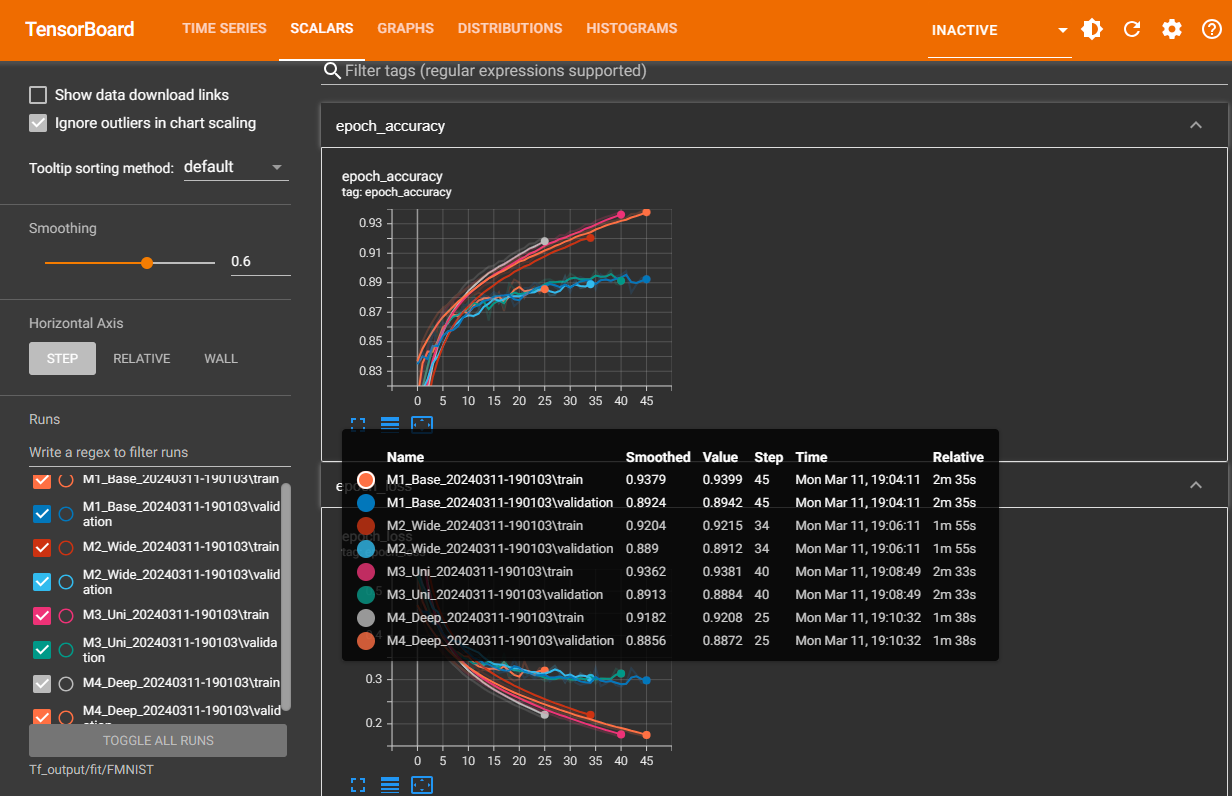

<h4 align="center"> Section 5: Predictive Performance Analysis </h4>

In [64]:
#Load best models for evaluation
best_dnn1 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn1")
best_dnn2 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn2")
best_dnn3 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn3")
best_dnn4 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn4")

In [65]:
#Evaluate best 'Model 1' on unseen test set
best_dnn1.evaluate(X_te_sc, y_te)

313/313 [==============================] - 1s 1ms/step - loss: 0.2986 - accuracy: 0.8952


[0.29862773418426514, 0.8952000141143799]

In [66]:
 #Verify result with original / non-loaded model
dnn1.evaluate(X_te_sc, y_te)

313/313 [==============================] - 0s 1ms/step - loss: 0.2986 - accuracy: 0.8952


[0.29862773418426514, 0.8952000141143799]

In [67]:
#Evaluate all best models + compile results in df

best_list = [best_dnn1, best_dnn2, best_dnn3, best_dnn4]

count_test_metrics = 0

test_df = pd.DataFrame(columns=['Test Loss', 'Test Accuracy'])

 #Loop
for model in best_list:
    loss, accuracy = model.evaluate(X_te_sc, y_te)
    test_df.loc[count_test_metrics] = [loss, accuracy]
    test_df.rename(index={count_test_metrics: 'Model '+str(count_test_metrics+1)}, inplace=True)
    count_test_metrics+=1

 #Present in df
test_df

313/313 [==============================] - 1s 1ms/step - loss: 0.3058 - accuracy: 0.8903


,Test Loss,Test Accuracy
Model 1,0.298628,0.8952
Model 2,0.305058,0.8921
Model 3,0.303990,0.8953
Model 4,0.305847,0.8903


In [68]:
#Generate + store predictions from models
preds1 = best_dnn1.predict(X_te_sc)
preds2 = best_dnn2.predict(X_te_sc)
preds3 = best_dnn3.predict(X_te_sc)
preds4 = best_dnn4.predict(X_te_sc)

313/313 [==============================] - 0s 1ms/step


In [69]:
#Review shapes for test label+prediction arrays
 #Prediction array includes one probability per class, for each instance
print(y_te.shape, preds1.shape)
print('Example classwise probabilities:')
pd.DataFrame({'Probabilities': preds1[0]})

(10000,) (10000, 10)
Example classwise probabilities:


,Probabilities
0,5.520159e-03
1,2.696023e-08
2,1.731616e-01
3,1.462366e-04
4,6.702681e-01
5,3.297009e-09
6,1.507865e-01
7,1.804985e-10
8,1.173094e-04
9,4.639933e-09


Instance #: 9486/10,000
True class of instance: tf.Tensor(1, shape=(), dtype=int8) (Trouser)
Predicted class of instance: 1 (Trouser)
Model's confidence in prediction: 0.99999976
AxesImage(shape=(28, 28))


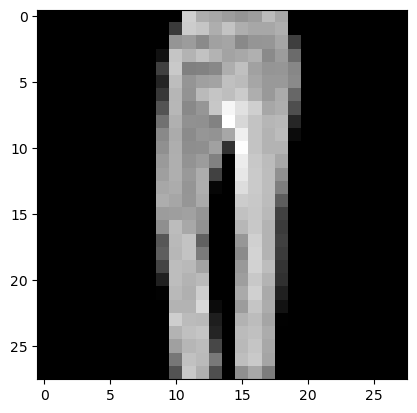

In [70]:
#Sample 3: Compare actual and predicted class for random prediction set instance
 #Select index value for sample
instance_val = random.randint(0,10000)

 #Store values
sample4 = X_te_sc[instance_val]
s4_class_true = y_te[instance_val]
s4_class_pred = np.argmax(preds1[instance_val])
s4_conf = max(preds1[instance_val])

 #Output instance #, true class, predicted class, and prediction confidence for sample
print('Instance #: '+str(instance_val+1)+'/10,000')
print('True class of instance: '+str(s4_class_true)+' ('+class_names[s4_class_true]+')')
print('Predicted class of instance: '+str(s4_class_pred)+' ('+class_names[s4_class_pred]+')')
print('Model\'s confidence in prediction: '+str(s4_conf))

#Display sample 4 image
print(plt.imshow(sample4, cmap='gray'));

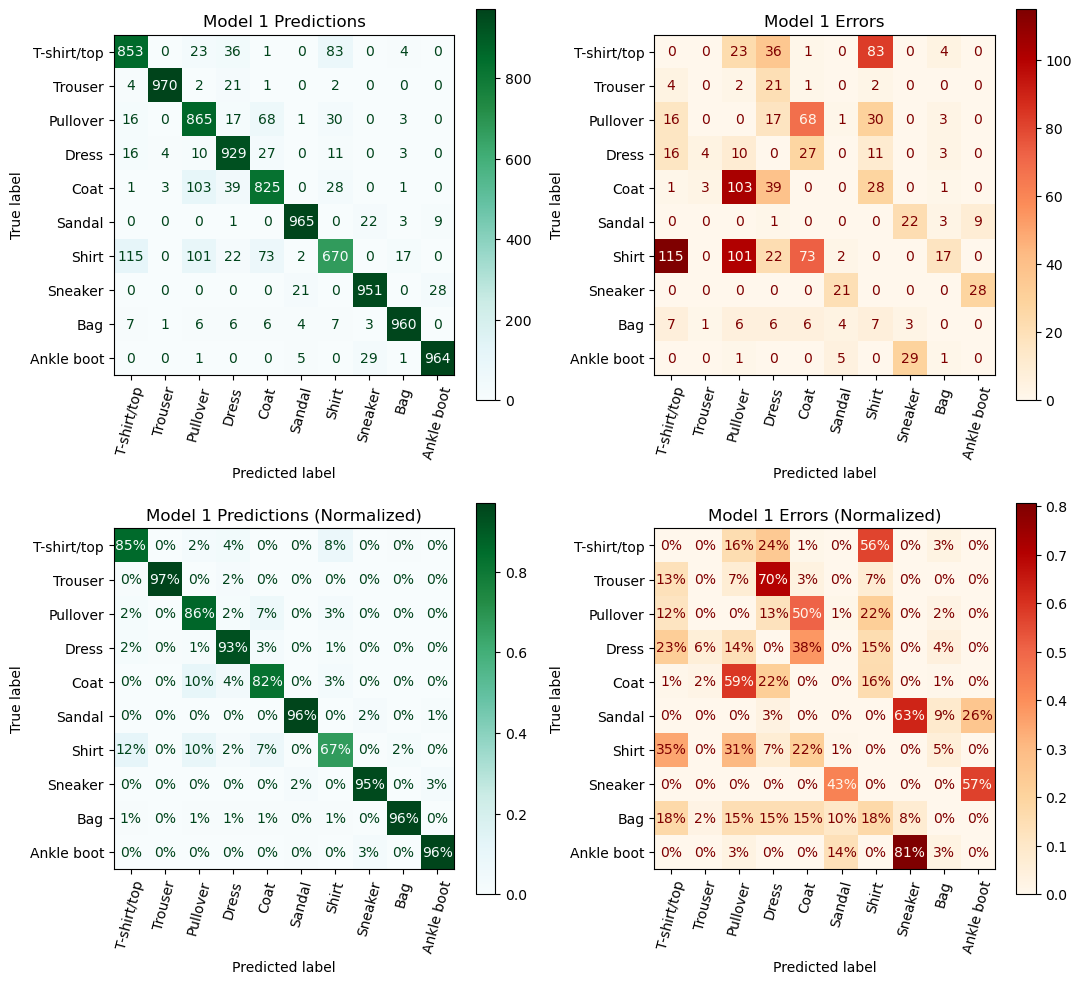

In [71]:
#Confusion Matrices: Model 1
sample_weights1 = (np.argmax(preds1, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 1c + 1d normalized by row
confusion_matrix1a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('Model 1 Predictions')
confusion_matrix1b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights1, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('Model 1 Errors')
confusion_matrix1c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('Model 1 Predictions (Normalized)')
confusion_matrix1d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights1, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('Model 1 Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

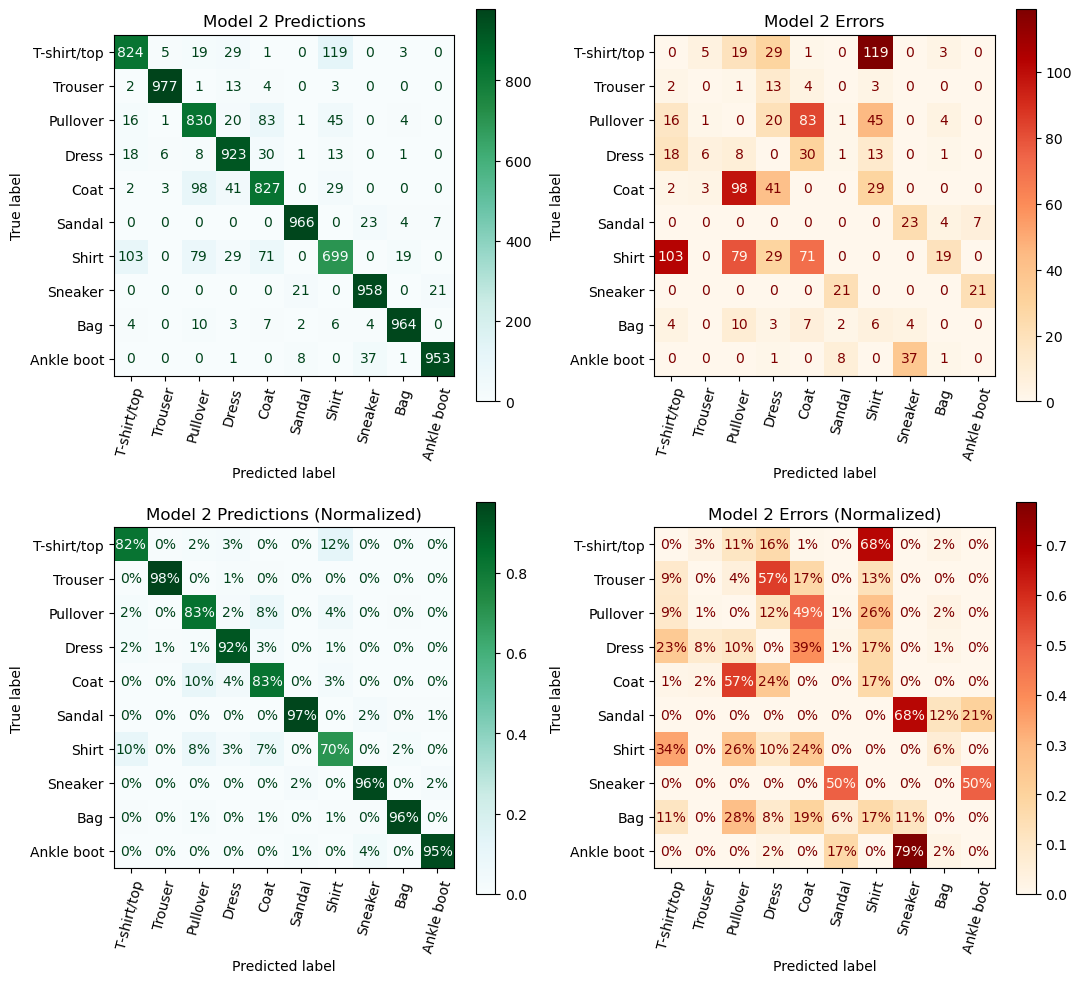

In [72]:
#Confusion Matrices: Model 2
sample_weights2 = (np.argmax(preds2, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 2c + 2d normalized by row
confusion_matrix2a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('Model 2 Predictions')
confusion_matrix2b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights2, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('Model 2 Errors')
confusion_matrix2c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('Model 2 Predictions (Normalized)')
confusion_matrix2d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights2, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('Model 2 Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

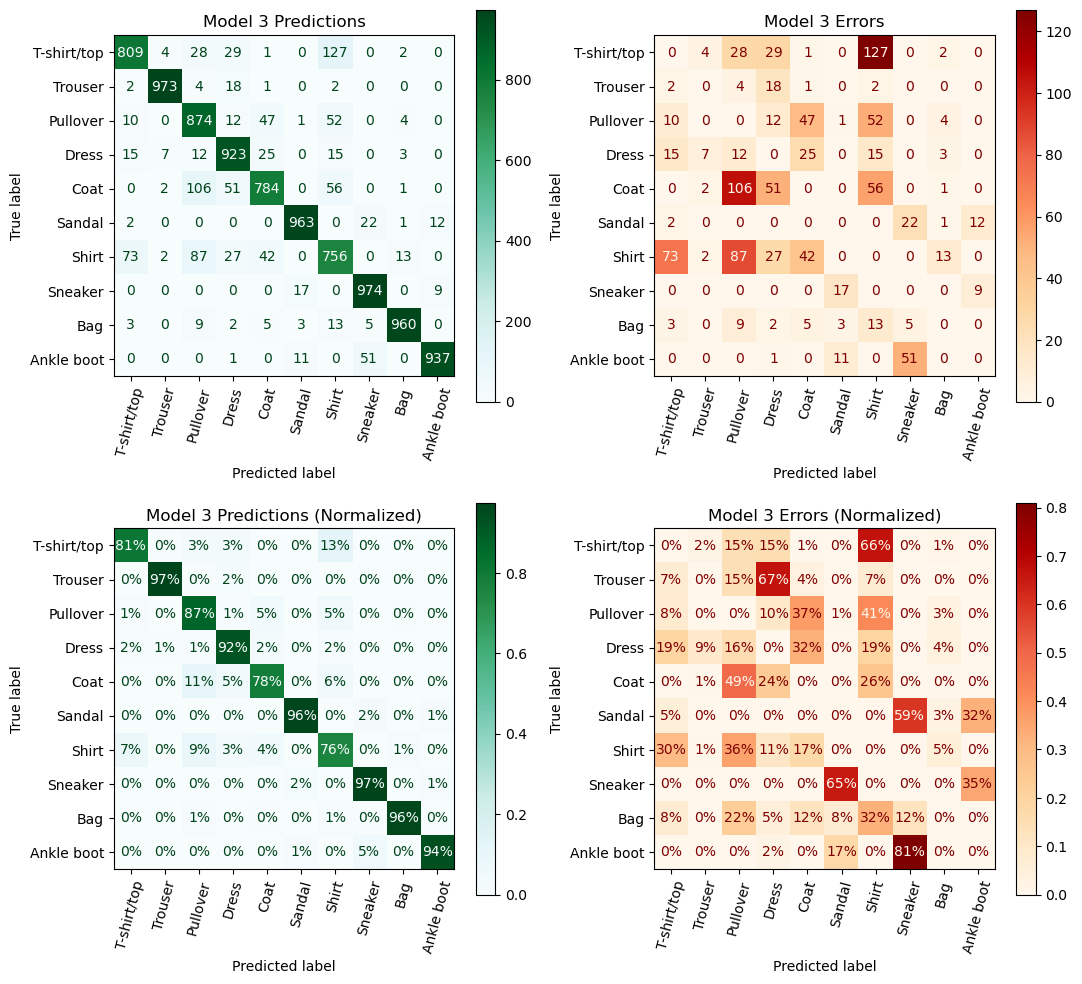

In [73]:
#Confusion Matrices: Model 3
sample_weights3 = (np.argmax(preds3, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 3c + 3d normalized by row
confusion_matrix3a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('Model 3 Predictions')
confusion_matrix3b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights3, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('Model 3 Errors')
confusion_matrix3c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('Model 3 Predictions (Normalized)')
confusion_matrix3d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights3, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('Model 3 Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

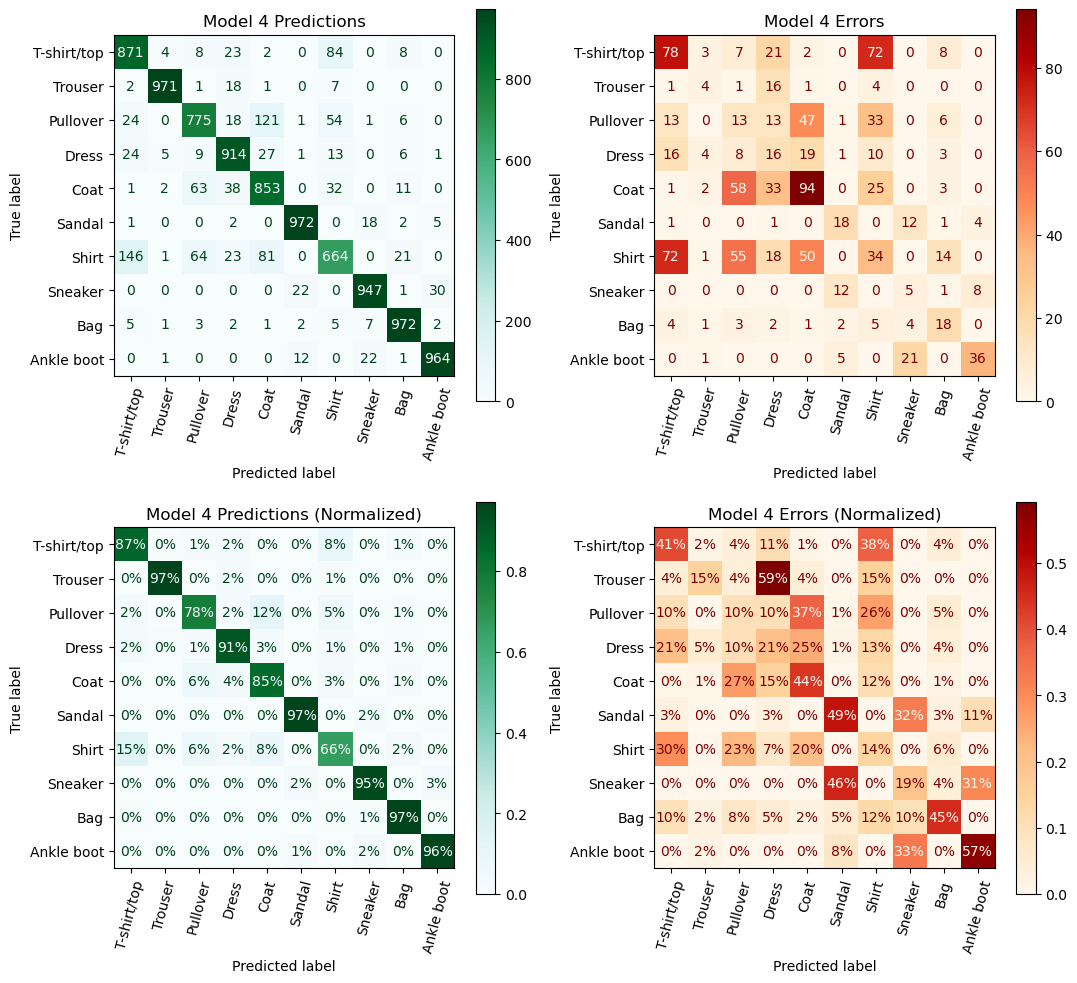

In [74]:
#Confusion Matrices: Model 4
sample_weights4 = (np.argmax(preds4, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 4c + 4d normalized by row
confusion_matrix4a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds4, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('Model 4 Predictions')
confusion_matrix4b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds4, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights3, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('Model 4 Errors')
confusion_matrix4c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds4, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('Model 4 Predictions (Normalized)')
confusion_matrix4d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds4, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights3, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('Model 4 Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

In [75]:
#Create dataframe of metrics corresponding to best weights, per model 

history_list = [history1, history2, history3, history4]
type_list = ['Baseline','Wide','Uniform','Deep']

results_df = pd.DataFrame(columns=['Type/Shape','# Convergence Epochs','Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss', 'Test Accuracy', 'Test Loss'])

count_hist_metrics = 0

for history in history_list:
    #Store training results in object
    train_results = history.history
    #Create dataframe of results object
    train_results_df = pd.DataFrame(history.history)
    #Find # of convergence epochs for best weights 
    best_epochs = np.argmin(train_results['val_loss'])
    #Find results corresponding to best weights/saved model
    best_row = train_results_df.iloc[best_epochs][['loss','accuracy','val_loss','val_accuracy']]
    #Insert results to df
    results_df.loc[count_hist_metrics] = [type_list[count_hist_metrics], best_epochs, best_row['accuracy'], best_row['loss'], best_row['val_accuracy'], best_row['val_loss'], test_df.loc['Model '+str(count_hist_metrics+1)]['Test Accuracy'], test_df.loc['Model '+str(count_hist_metrics+1)]['Test Loss']]
    results_df.rename(index={count_hist_metrics: 'Model '+str(count_hist_metrics+1)}, inplace=True)
    count_hist_metrics+=1

results_df

,Type/Shape,# Convergence Epochs,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss
Model 1,Baseline,40,0.933582,0.186408,0.8952,0.284086,0.8952,0.298628
Model 2,Wide,29,0.915818,0.232442,0.8944,0.293644,0.8921,0.305058
Model 3,Uniform,35,0.931909,0.187794,0.8984,0.291498,0.8953,0.303990
Model 4,Deep,19,0.910200,0.242908,0.8922,0.296907,0.8903,0.305847


# <h2 align="center"> Development Notes </h2>

<b><u>Model Notes<u/><b/>
- Modified "Uniform" and "Deep" models to hold "total trainable parameters" (or "model size") constant rather than "total # neurons" for comparison
  - Performance for initial Uniform (2 layers, 200 neurons ea.) and Deep (3 layers, \~133 neurons ea.) models varied, but was generally slightly worse (\~1% less accurate than Model 1 on train + val) 
    - While deeper networks have higher parameter efficiency, holding "total # neurons" constant meant narrowing the first dense layer to add depth
      - This reduced total trainable parameters more severely than narrowing other layers would (e.g., 784\*300 vs \*200 or \*134), as well as the network's capacity to learn fundamental low-level features.
- Added "Wide" model

<u><b>Data Engineering Process Notes<b/><u/>
- Imported full csv data to DataFrame
  - Sample 1a: randomly sampled data instance; reshaped, identified class/category, and displayed image
- Transformed df to 1- (labels) and 3-dimensional (features) ndarrays; reshaped feature array
  - Sample 1b: re-located 1a by index; identified, and displayed image
- Evaluated two methods for splitting data while preserving dataset balance; selected sklearn over keras method for precise stratification
  - Performed train/validation/test data splits
  - Scaled features to optimize for gradient descent
- Transformed numpy arrays to Tensorflow tensors
  - Provides GPU support (not supported in Windows), computational graphs for parallelization, gradient tape for auto-differentiation
  - Reduced precision/bit depth of tensors to reduce memory use and computational cost
  - Sample 2: accessed new instance from tensor (instances re-indexed by splitting); identified, and displayed image
- Centralized output directory
  - Created separate event log directories, event log and checkpoint callbacks
    - Single callback stored all events as single log, limiting utility in tensorboard
- Reused single early stopping callback, after verifying that each trained model still returned separate "best weights" (i.e., early stopping callback object did not retain weights between models
- Accessed pre-training & trained model/layer weights & biases
- Saved and loaded models in tensorflow format
- Sample 3: randomly sampled test set; compared model prediction to ground truth label, output prediction confidence, and displayed image

<b><u>Notebook Code Notes<u/><b/>
  - Scalability
    - Streamlined inclusion of additional models using condensed code, loops & lists (e.g., training/history creation, evaluation df, full results df)
  - Readability
    - Added DataFrames for results
    - Simplified code and commented portions out
    - Renamed variables
    - Reformatted

<h2 align="center"> Evaluation of Performance by Model </h2>

<b>All models are compared to "Baseline"<b>

<b><u>Model 1: "Baseline"<u/><b/>
- 2 dense hidden layers; 300 & 100 neurons
- Training accuracy exceeding validation accuracy before/around ~Epoch 10 indicates subsequent overfitting
- Convergence rate: 40 epochs (limit: 50, patience: 5)
- Task metrics
  - Test accuracy achieved: ~0.89-0.90
    - Highest for Trousers, Sandals, Sneakers, Bags, and Ankle Boots (95%+)
    - Lowest for T-shirt/tops, Pullovers, Dresses, Coats, Shirts (~66-86%)
  - Has the most difficulty distinguishing between clothing shapes made for upper-body, listed above (understandable, due to similarities/ambiguity)
    - 'Shirts' are particularly difficult to correctly classify (~66%)

<b><u>Model 2: "Wide"<u/><b/>
- 2 dense hidden layers; 334 & 12 neurons
  - Wider first layer, narrower second layer
- Convergence rate: faster by 11 epochs
- Task metrics
  - Lower training (\~-2%) and test accuracy (~-0.3%)
 
<b><u>Model 3.1: "Uniform"<u/><b/>
- 3 dense hidden layers; ~216 neurons ea.
  - Narrower, uniform shape
- Convergence rate: slightly faster, by 5 epochs
- Task metrics
  - Nearly equivalent training (~-0.15%) and test accuracy (+0.01%)

<b><u>Model 4.1: "Deep"<u/><b/>
- 4 dense hidden layers; ~193 neurons ea.
  - Narrower, deeper, uniform shape
- Convergence rate: fastest; under 1/2 the epochs
- Task metrics
  - Lower training (>-2%) and test accuracy (~-0.5%)

<b><u>Model 5: "Neuron dropout"<u/><b/>
  
<b><u>Model 6: "Wide & Deep"<u/><b/>

<b><u>Model 7: "Convolutional Neural Network (CNN)"<u/><b/>

<h2 align="center"> Conclusions </h2>

- In this trial, when evaluated on previously unseen data, the most accurate model was "Uniform" by 0.01%, closely followed by "Baseline"
  - Despite all layers being narrowed by 85 neurons, the additional layer of depth may be responsible for equivalent/better performance
- The least accurate model by "test accuracy" was "Deep"
  - First dense layer is over 2/3 narrower than "Baseline"'s
    - This reduces the model's ability to learn lower-level features, limiting the benefit of additional layers for higher-level features
- Largely similar validation & test accuracies, along with higher relative training accuracies, indicates all models have overfit
  - This is also visible before epoch 10 in the learning curve visualizations